#Image Classification with CNN

##1)-Importing Libraries

In [37]:
# DeepLearning resources
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization

# Data preprocessing and performance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Data management resources
import numpy as np
import matplotlib.pyplot as plt

# Data set resources
from tensorflow.keras.datasets import cifar10

##2)-Data Importing and exploration

In [22]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [23]:
print(x_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000, 1)


We can see that the dataset is conformed by 50000 images of multiple objects with dimentions 32 x 32 with three channels.

In [24]:
x_train.shape

(50000, 32, 32, 3)

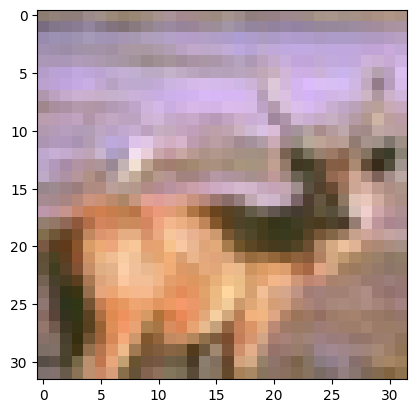

In [25]:
plt.imshow(x_train[9000])

##3)-Data Cleaning

We have that the matrix elements have values between 0 to 255, then, for ease of simplicity and model speed, we normalize those values.

In [5]:
x_train[1][1][0:6]

array([[140, 160, 169],
       [145, 153, 154],
       [125, 125, 118],
       [124, 129, 132],
       [150, 161, 173],
       [152, 164, 175]], dtype=uint8)

In [26]:
# x_train = x_train.astype('float32')/255
# x_test = x_test.astype('float32')/255

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

On the other hand, the labels for the classification task is encoded in integer-valued arrays, then we need to perform one-hot encoding.

In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [27]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
y_train[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

###3.1-Data normalization

A practice that helps to improve the convergence performance of convolutional networks is the standardization of the training and test data, however, we proceed to determine the mean and standard deviation of the training data to find the z-score of both the training data and the z-score of the test data. This is done because calculating the mean and standard deviation of the test data to determine its z-score would be equivalent to generating a model with bias.

In [28]:
mean = np.mean(x_train)
std = np.std(x_train)

In [29]:
x_train = (x_train - mean)/(std*1e-7)
x_test = (x_test - mean)/(std*1e-7)

As a good practice, we further divide the dataset, taking the training dataset and dividing it in train and validation sets.

In [30]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('train shape: ', (x_train.shape)[0])
print('validation shape: ', (x_valid.shape)[0])
print('test shape: ', (x_test.shape)[0])


train shape:  45000
validation shape:  5000
test shape:  10000


##4)-CNN model creation

In [31]:
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [32]:
# Hiper parameters
base_filtros = 32
w_regularizer = 1e-4
in_shape = x_train.shape[1:]

# -------------------------- CNN Model --------------------------
model = Sequential()
# Conv1
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=in_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())

# ------- Feature Extraction -------
# Conv2
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=in_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Conv3
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=in_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Conv4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=in_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Conv5
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=in_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=in_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# ------- Classification -------
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_13 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_14 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                     

###4.1-Data Augmentation and train

In [43]:
# Data augmentation generator
datagenerator = ImageDataGenerator(rotation_range=15,
                   width_shift_range=0.1,
                   height_shift_range=0.1,
                   horizontal_flip=True,
                   vertical_flip=True)

In [42]:
# Model Adam optimizer
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics = ['accuracy'])

The following fit process is the general protocole maded for a CNN without data aumentation.

In [ ]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=100,
                 validation_data=(x_valid, y_valid),
                 verbose=2, shuffle=True)

In order to acomodate the process to the data generator we need to include it explicitly during the training stage. We include also a checkpoint function.

In [45]:
checkpoint = ModelCheckpoint('my_best_model.hdf5',verbose=1,
                             save_best_only=True,
                             monitor = 'val_accuracy')

In [47]:
hist = model.fit(datagenerator.flow(x_train, y_train), batch_size=128,
          callbacks=[checkpoint],
          steps_per_epoch = x_train.shape[0]//128,
          epochs=120,
          validation_data=(x_valid, y_valid))

Epoch 1/120
350/351 [============================>.] - ETA: 0s - loss: 2.6959 - accuracy: 0.2599
Epoch 1: val_accuracy improved from -inf to 0.32000, saving model to my_best_model.hdf5
351/351 [==============================] - 26s 30ms/step - loss: 2.6956 - accuracy: 0.2601 - val_loss: 2.1542 - val_accuracy: 0.3200
Epoch 2/120
350/351 [============================>.] - ETA: 0s - loss: 2.1969 - accuracy: 0.3236
Epoch 2: val_accuracy improved from 0.32000 to 0.35440, saving model to my_best_model.hdf5
351/351 [==============================] - 9s 25ms/step - loss: 2.1951 - accuracy: 0.3238 - val_loss: 1.9051 - val_accuracy: 0.3544
Epoch 3/120
349/351 [============================>.] - ETA: 0s - loss: 2.0004 - accuracy: 0.3661
Epoch 3: val_accuracy improved from 0.35440 to 0.41520, saving model to my_best_model.hdf5
351/351 [==============================] - 10s 27ms/step - loss: 1.9998 - accuracy: 0.3660 - val_loss: 1.8739 - val_accuracy: 0.4152
Epoch 4/120
350/351 [====================

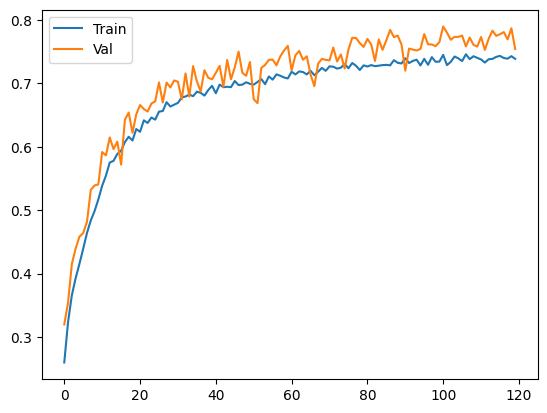

In [48]:
plt.plot(hist.history['accuracy'],label='Train')
plt.plot(hist.history['val_accuracy'],label='Val')
plt.legend()
plt.show()

In [49]:
model2 = model
model2.load_weights('./my_best_model.hdf5')

In [52]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.8524 - accuracy: 0.7782


[0.852389931678772, 0.7781999707221985]